 # Requerimientos

In [1]:
# Importamos las librerías
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import spacy.cli
import nltk
nltk.download('punkt')
import sklearn.manifold
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

[nltk_data] Downloading package punkt to /home/sofiuwu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Descargamos el modelo del español provisto por spacy
spacy.cli.download("es_core_news_md")

Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


# Carga del dataset

In [3]:
# Abrir y leer el archivo
nlp = spacy.load("es_core_news_md")

filename = "recursos/poesia_completa.txt"
text_file = open(filename, "r")
dataset = text_file.read()
text_file.close()

doc = nlp(dataset.lower())

In [4]:
# Eliminamos las oraciones con menos de 10 palabras
sents = [sent for sent in doc.sents if len(sent) > 10]

In [5]:
# Creamos una lista con las palabras procesadas, evitando aquellas que sean puntuaciones, números o desconocidas.
words = []
lemmas = []

for sent in sents:
    for word in sent:
        if word.is_alpha and len(word) > 2 and (not word.is_stop):
            words.append(word)
            lemmas.append(word.lemma_)


In [6]:
# Contamos las ocurrencias de cada lemma encontrado
lemma_counter = Counter(lemmas)

# Creación del diccionario

In [7]:
dictionary = {}
discarded_words = []
threshold = 30

In [8]:
def get_context(features, context, counts):
    for c_word in context:
        c_lemma = c_word.lemma
    if c_word.is_alpha and (counts[c_lemma] > threshold):
        if str.isdigit(str(c_lemma)):
            c_lemma = "NUM__"
        features = features.get(c_lemma, 0) + 1

In [9]:
for i in range(len(words)):
    features = {}
    word = words[i]
    word_lemma = lemmas[i]

    if word_lemma in dictionary:
        features = dictionary[word_lemma]

    pos = "POS__" + str(word.pos_)
    dep = "DEP__" + str(word.dep_)

    features[pos] = features.get(pos, 0) + 1
    features[dep] = features.get(dep, 0) + 1
    if word.i != 0: # Si no es la primera palabra de la oración
        context_left = doc[word.i - 2: word.i] if word.i > 2 else doc[word.i - 1: word.i]
        get_context(features, context_left, lemma_counter)

    if word.i != len(doc) - 1: # Si no es la última
        context_right = doc[word.i + 1 : word.i + 3] if word.i < len(doc) - 2 else doc[word.i + 1 : word.i + 2]
        get_context(features, context_right, lemma_counter)

    dictionary[word_lemma] = features

In [10]:
# Añadimos las keywords al diccionario
kwords = {}
all_features = []
for i in range(len(dictionary)):
    word = list(dictionary.keys())[i]
    all_features.append(dictionary[word])
    kwords[word] = i

# Vectorización y normalización

In [11]:
threshold_var = 0.001

In [12]:
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(all_features)

matrix_normed = matrix / matrix.max(axis=0)

variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

red_matrix = np.delete(matrix_normed, np.where(variances < threshold_var), axis=1)

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

# Clustering

In [13]:
# Usamos el algoritmo de k-means con distancias de coseno para clustering
def clustering(k, matrix):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix, True)
    return clusters

In [14]:
clusters = clustering(100, red_matrix)

/home/sofiuwu/.local/lib/python3.9/site-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


<AxesSubplot:xlabel='x', ylabel='y'>

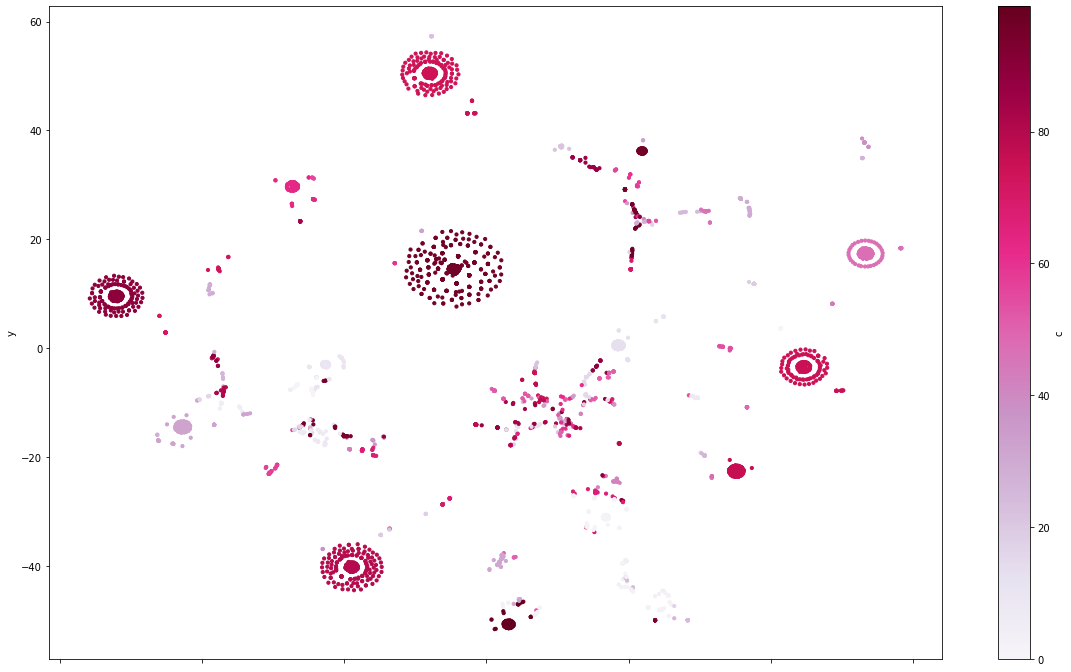

In [15]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[kwords[word]], clusters[kwords[word]])
            for word in kwords
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='PuRd', s=10, figsize=(20, 12))

In [36]:
def get_words(cluster, search):
    return [word for word in kwords if cluster[kwords[word]] == cluster[kwords[search]]]

In [37]:
cluster_1 = clustering(25, red_matrix)
cluster_2 = clustering(50, red_matrix)
cluster_3 = clustering(75, red_matrix)

In [38]:
print(get_words(cluster_1, "beso"))

['egoísmo', 'curva', 'imán', 'encía', 'huella', 'retret', 'beso', 'calandria', 'confitura', 'rugido', 'copa', 'promesa', 'locuacidad', 'ronda', 'esfinge', 'montón', 'costura', 'arpa', 'luna', 'desnudez', 'basura', 'innato', 'olor', 'brisa', 'trenza', 'bagaje', 'devenir', 'cola', 'crín', 'verso', 'letra', 'extrañeza', 'cáliz', 'calavera', 'pedazo', 'escultura', 'línea', 'rodilla', 'reloj', 'ajedrez', 'peón', 'millar', 'exquisita', 'torta', 'barba', 'onda', 'kilómetro', 'carne', 'marco', 'envoltura', 'boleto', 'rostro', 'imagen', 'estética', 'asiento', 'pez', 'sonido', 'borbotón', 'miedo', 'hermano', 'cuerda', 'sensación', 'oído', 'barco', 'don', 'paciente', 'suela', 'espesura', 'pasto', 'aspiración', 'sudor', 'embeleso', 'perfil', 'trama', 'festival', 'punto', 'anhelante', 'cocktail', 'murciélago', 'mosquita', 'juventud', 'efigie', 'burbuja', 'altura', 'caricia', 'carromato', 'vuelo', 'secreto', 'mustia', 'innata', 'armonía', 'pensamiento', 'sirena', 'puerta', 'fruto', 'muralla', 'odio'

In [39]:
print(get_words(cluster_1, "sombra"))

['tierra', 'forma', 'voz', 'sombra', 'sol', 'perro', 'flor', 'ojo', 'noche', 'poema', 'vida', 'muerte', 'cuerpo', 'color', 'corazón', 'amor', 'palabra', 'ceniza', 'alma', 'oscuridad', 'centro', 'niño', 'casa', 'infancia', 'jardín', 'lenguaje', 'texto']


In [40]:
print(get_words(cluster_2, "silencio"))

['hoja', 'beso', 'estrella', 'existencia', 'arpa', 'fuente', 'luna', 'luz', 'viento', 'gesto', 'sonrisa', 'deseo', 'límite', 'paso', 'pecho', 'carne', 'rostro', 'imagen', 'brazo', 'miedo', 'espacio', 'locura', 'barco', 'nombre', 'angustia', 'inocencia', 'ventana', 'espejo', 'mensaje', 'canto', 'pavor', 'terror', 'destino', 'pregunta', 'boca', 'cansancio', 'cuchillo', 'maleza', 'herida', 'razón', 'silencio', 'interés', 'paz', 'paloma', 'raíz', 'conocimiento', 'elemento', 'náufrago', 'furor', 'orfandad', 'otoño', 'arena', 'hierba', 'iglesia', 'dicha', 'muchacho', 'pierna', 'templo', 'llamamiento', 'asfixia', 'gallo', 'corrección', 'autora', 'confusión', 'orden', 'sentimiento', 'agonía', 'prefacio', 'aristeguieta']


In [41]:
print(get_words(cluster_2, "palabra"))

['voz', 'sombra', 'sol', 'perro', 'mar', 'flor', 'ojo', 'noche', 'poema', 'vida', 'muerte', 'cuerpo', 'color', 'corazón', 'amor', 'palabra', 'pájaro', 'ceniza', 'alma', 'infancia', 'jardín', 'lenguaje']


In [42]:
print(get_words(cluster_3, "ojo"))

['tierra', 'voz', 'sombra', 'ojo', 'hombre', 'lejanía', 'vino', 'espuma', 'niño', 'animal', 'lengua', 'sed']


In [43]:
print(get_words(cluster_3, "color"))

['sol', 'mar', 'noche', 'vida', 'muerte', 'cuerpo', 'color', 'llanto', 'palabra', 'pájaro', 'ceniza', 'alma', 'centro', 'infancia', 'jardín', 'escritura', 'lenguaje', 'posesión']
